In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

In [35]:
df = pd.read_csv('heart_disease_health_indicators.csv')
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


In [36]:
df.duplicated().sum()

23899

In [37]:
df.drop_duplicates()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253656,0,0,0,1,25,0,0,0,1,1,...,1,0,1,0,0,0,0,4,6,8
253657,0,0,1,1,24,0,0,0,0,0,...,1,0,3,0,0,0,0,7,5,3
253658,0,0,0,0,27,0,0,0,1,0,...,1,1,2,0,0,0,0,3,6,5
253659,0,0,1,1,37,0,0,2,0,0,...,1,0,4,0,0,0,0,6,4,1


In [38]:
scaler = StandardScaler()
df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

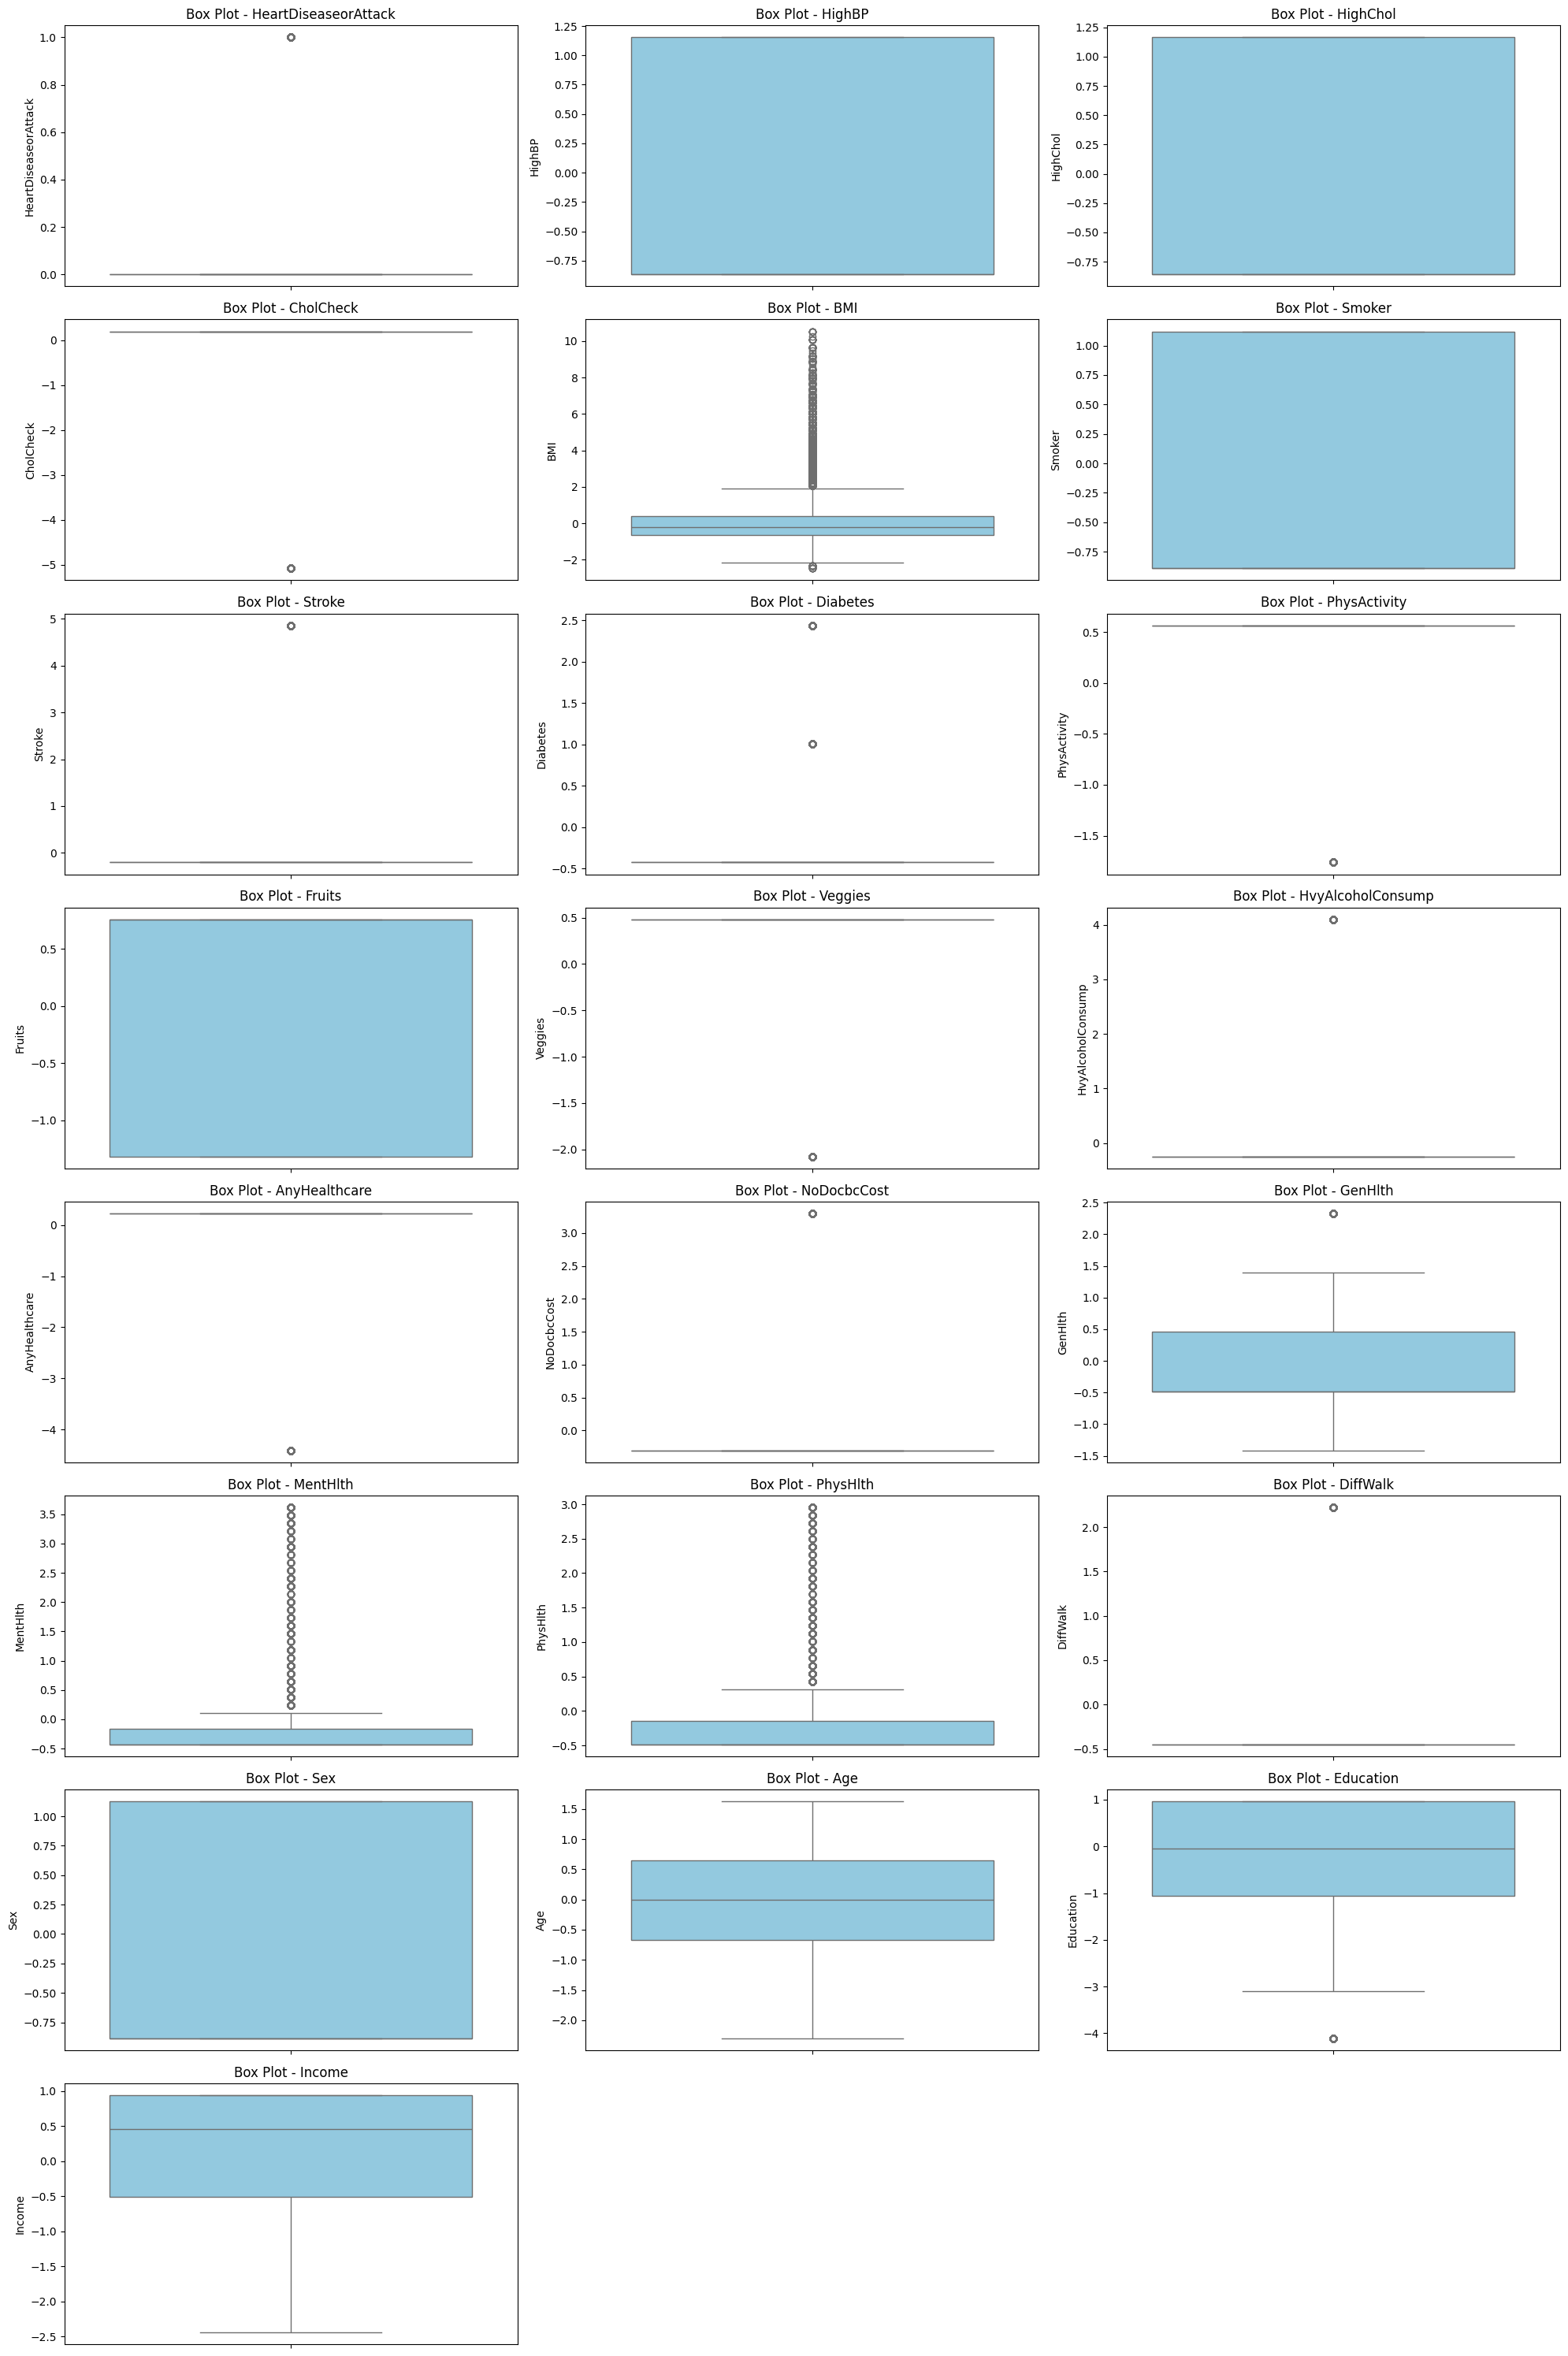

In [39]:
plt.figure(figsize=(20, 30))

for i, column in enumerate(df.columns, 1):
    plt.subplot(len(df.columns) // 3 + 1, 3, i)  
    sns.boxplot(data=df[column], color='skyblue')
    plt.title(f'Box Plot - {column}')
    plt.tight_layout()

plt.show()


In [40]:
bmi_upper = df['BMI'].quantile(0.75)
phys_upper = df['PhysHlth'].quantile(0.75)
ment_upper = df['MentHlth'].quantile(0.75)
genhealth_upper = df['GenHlth'].quantile(0.75)
education_lower = df['Education'].quantile(0.25)

df_filtered = df[
    (df['BMI'] <= bmi_upper) & 
    (df['PhysHlth'] <= phys_upper) & 
    (df['MentHlth'] <= ment_upper) & 
    (df['GenHlth'] <= genhealth_upper) & 
    (df['Education'] >= education_lower)
]

print(f"Original dataset shape: {df.shape}")
print(f"Filtered dataset shape: {df_filtered.shape}")


Original dataset shape: (253661, 22)
Filtered dataset shape: (119338, 22)


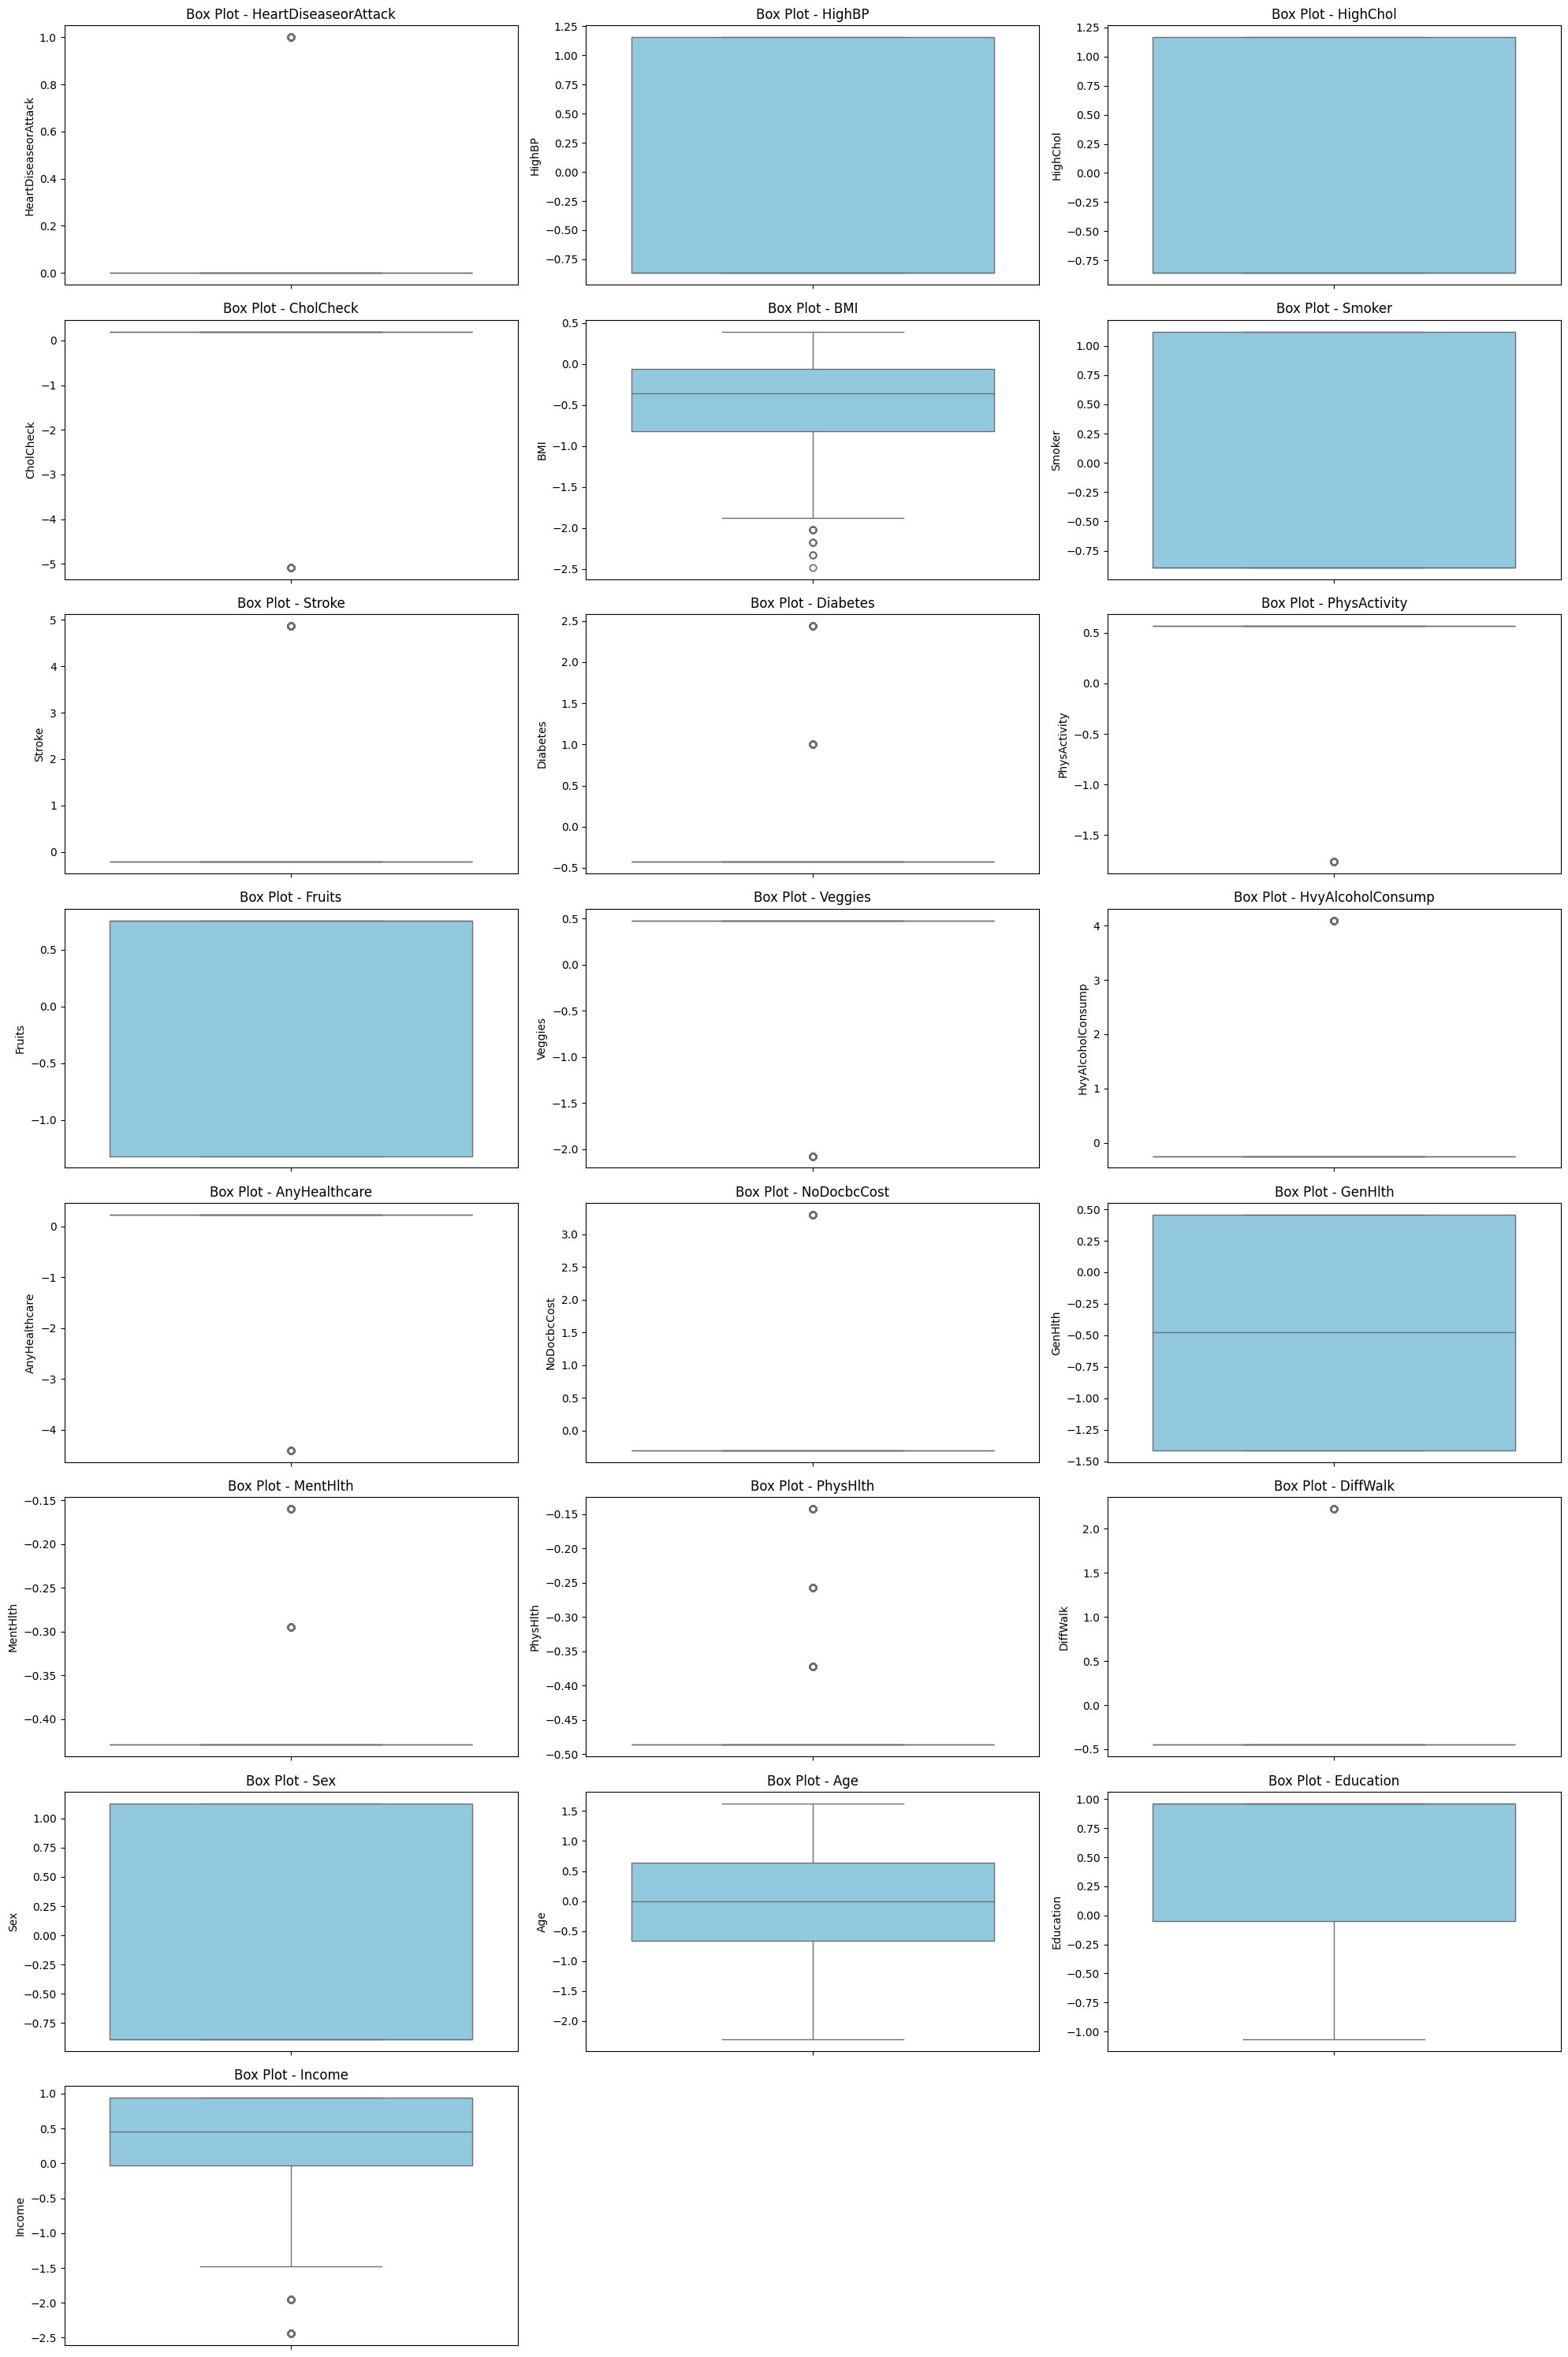

In [41]:
plt.figure(figsize=(20, 30))

for i, column in enumerate(df.columns, 1):
    plt.subplot(len(df_filtered.columns) // 3 + 1, 3, i)  
    sns.boxplot(data=df_filtered[column], color='skyblue')
    plt.title(f'Box Plot - {column}')
    plt.tight_layout()

plt.show()


In [42]:
bmi_lower = df_filtered['BMI'].quantile(0.25)
income_lower = df_filtered['Income'].quantile(0.25)

df_filtered = df_filtered[
    (df_filtered['BMI'] >= bmi_lower) & 
    (df_filtered['Income'] <= income_lower) 
]

In [43]:
X = df_filtered.drop('HeartDiseaseorAttack', axis=1)
y = df_filtered['HeartDiseaseorAttack']

In [44]:
y.value_counts()

HeartDiseaseorAttack
0    31892
1     2810
Name: count, dtype: int64

In [45]:
sampling_strategy = {0: y.value_counts()[0], 1: y.value_counts()[0]}  

smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
X ,y = smote.fit_resample(X ,y)

print("Class distribution after SMOTE:")
print(y.value_counts())

Class distribution after SMOTE:
HeartDiseaseorAttack
0    31892
1    31892
Name: count, dtype: int64


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [47]:
model = Sequential([
    Dense(512, input_shape=(X_train.shape[1],), activation='relu'), 
    Dropout(0.5),
    BatchNormalization(), 

    Dense(256, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),

    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(64, activation='relu'),
    BatchNormalization(),

    Dense(32, activation='relu'),
    BatchNormalization(),

    Dense(16, activation='relu'),
    BatchNormalization(),
    
    Dense(1, activation='sigmoid') 
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 512)               11264     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_7 (Bat  (None, 256)               1024      
 chNormalization)                                     

In [48]:
def lr_schedule(epoch, lr):
    if epoch < 10:  
        return lr 
    elif epoch % 10 == 0:  
        return lr * 0.5  
    else:  
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


In [49]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [50]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=[lr_scheduler]
)

Epoch 1/100
160/160 [==============================] - 4s 10ms/step - loss: 0.5277 - accuracy: 0.7392 - val_loss: 0.8737 - val_accuracy: 0.7407 - lr: 0.1000
Epoch 2/100
160/160 [==============================] - 1s 8ms/step - loss: 0.5038 - accuracy: 0.7547 - val_loss: 0.7039 - val_accuracy: 0.7384 - lr: 0.1000
Epoch 3/100
160/160 [==============================] - 1s 8ms/step - loss: 0.4935 - accuracy: 0.7644 - val_loss: 0.5631 - val_accuracy: 0.7655 - lr: 0.1000
Epoch 4/100
160/160 [==============================] - 1s 8ms/step - loss: 0.4893 - accuracy: 0.7672 - val_loss: 0.5543 - val_accuracy: 0.7576 - lr: 0.1000
Epoch 5/100
160/160 [==============================] - 1s 8ms/step - loss: 0.4843 - accuracy: 0.7686 - val_loss: 0.5182 - val_accuracy: 0.7717 - lr: 0.1000
Epoch 6/100
160/160 [==============================] - 1s 9ms/step - loss: 0.4798 - accuracy: 0.7729 - val_loss: 0.4925 - val_accuracy: 0.7761 - lr: 0.1000
Epoch 7/100
160/160 [==============================] - 1s 8ms/s

In [52]:
def lr_schedule(epoch, lr):
    if epoch < 20:  
        return 0.01 
    elif epoch % 20 == 0:  
        return lr * 0.7  
    else:  
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


In [53]:
history1 = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=256,
    callbacks=[lr_scheduler]
)

Epoch 1/200
160/160 [==============================] - 1s 8ms/step - loss: 0.3308 - accuracy: 0.8547 - val_loss: 0.3079 - val_accuracy: 0.8673 - lr: 0.0100
Epoch 2/200
160/160 [==============================] - 1s 8ms/step - loss: 0.3298 - accuracy: 0.8562 - val_loss: 0.3077 - val_accuracy: 0.8688 - lr: 0.0100
Epoch 3/200
160/160 [==============================] - 1s 8ms/step - loss: 0.3305 - accuracy: 0.8549 - val_loss: 0.3181 - val_accuracy: 0.8651 - lr: 0.0100
Epoch 4/200
160/160 [==============================] - 1s 9ms/step - loss: 0.3306 - accuracy: 0.8544 - val_loss: 0.3060 - val_accuracy: 0.8668 - lr: 0.0100
Epoch 5/200
160/160 [==============================] - 1s 8ms/step - loss: 0.3309 - accuracy: 0.8550 - val_loss: 0.3262 - val_accuracy: 0.8625 - lr: 0.0100
Epoch 6/200
160/160 [==============================] - 1s 9ms/step - loss: 0.3294 - accuracy: 0.8546 - val_loss: 0.3159 - val_accuracy: 0.8640 - lr: 0.0100
Epoch 7/200
160/160 [==============================] - 1s 8ms/st

In [54]:
history = {
    key: history.history[key] + history1.history[key]
    for key in history.history
}


In [56]:
def lr_schedule(epoch, lr):
    if epoch < 30:  
        return 0.001 
    elif epoch % 30 == 0:  
        return lr * 0.9 
    else:  
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


In [57]:
history2 = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=256,
    callbacks=[lr_scheduler]
)

Epoch 1/200
160/160 [==============================] - 1s 9ms/step - loss: 0.2467 - accuracy: 0.8956 - val_loss: 0.2388 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 2/200
160/160 [==============================] - 1s 8ms/step - loss: 0.2498 - accuracy: 0.8948 - val_loss: 0.2351 - val_accuracy: 0.9051 - lr: 0.0010
Epoch 3/200
160/160 [==============================] - 1s 8ms/step - loss: 0.2456 - accuracy: 0.8949 - val_loss: 0.2344 - val_accuracy: 0.9055 - lr: 0.0010
Epoch 4/200
160/160 [==============================] - 1s 8ms/step - loss: 0.2496 - accuracy: 0.8944 - val_loss: 0.2456 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 5/200
160/160 [==============================] - 1s 8ms/step - loss: 0.2490 - accuracy: 0.8941 - val_loss: 0.2379 - val_accuracy: 0.9060 - lr: 0.0010
Epoch 6/200
160/160 [==============================] - 1s 8ms/step - loss: 0.2481 - accuracy: 0.8949 - val_loss: 0.2391 - val_accuracy: 0.9047 - lr: 0.0010
Epoch 7/200
160/160 [==============================] - 1s 8ms/st

In [59]:
history = {
    key: history[key] + history2.history[key]
    for key in history
}


In [60]:
def lr_schedule(epoch, lr):
    if epoch < 50:  
        return 0.0001 
    elif epoch % 50 == 0:  
        return lr * 0.95
    else:  
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


In [61]:
history3 = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=256,
    callbacks=[lr_scheduler]
)

Epoch 1/500
160/160 [==============================] - 1s 9ms/step - loss: 0.2373 - accuracy: 0.8993 - val_loss: 0.2323 - val_accuracy: 0.9119 - lr: 1.0000e-04
Epoch 2/500
160/160 [==============================] - 1s 8ms/step - loss: 0.2354 - accuracy: 0.9002 - val_loss: 0.2311 - val_accuracy: 0.9120 - lr: 1.0000e-04
Epoch 3/500
160/160 [==============================] - 1s 8ms/step - loss: 0.2361 - accuracy: 0.8996 - val_loss: 0.2320 - val_accuracy: 0.9117 - lr: 1.0000e-04
Epoch 4/500
160/160 [==============================] - 1s 8ms/step - loss: 0.2380 - accuracy: 0.9002 - val_loss: 0.2321 - val_accuracy: 0.9114 - lr: 1.0000e-04
Epoch 5/500
160/160 [==============================] - 1s 8ms/step - loss: 0.2382 - accuracy: 0.8990 - val_loss: 0.2323 - val_accuracy: 0.9114 - lr: 1.0000e-04
Epoch 6/500
160/160 [==============================] - 1s 8ms/step - loss: 0.2376 - accuracy: 0.8994 - val_loss: 0.2328 - val_accuracy: 0.9109 - lr: 1.0000e-04
Epoch 7/500
160/160 [===================

In [62]:
history = {
    key: history[key] + history3.history[key]
    for key in history
}

In [63]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

399/399 [==============================] - 1s 2ms/step - loss: 0.2296 - accuracy: 0.9122
Test Accuracy: 91.22%


In [64]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

399/399 [==============================] - 1s 2ms/step


In [67]:
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[5779  600]
 [ 520 5858]]


In [68]:
print('Classification Report:\n', classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91      6379
           1       0.91      0.92      0.91      6378

    accuracy                           0.91     12757
   macro avg       0.91      0.91      0.91     12757
weighted avg       0.91      0.91      0.91     12757



399/399 [==============================] - 1s 2ms/step


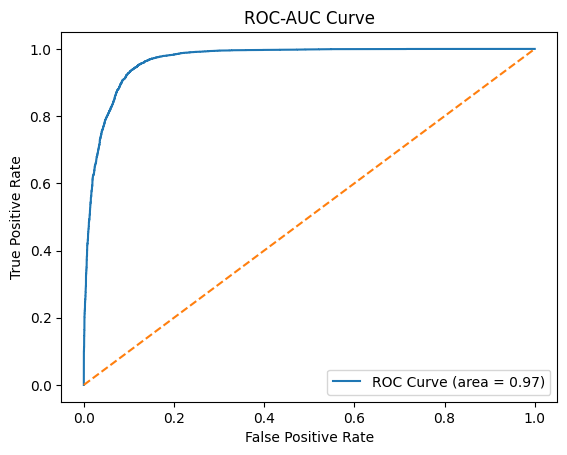

In [69]:
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='best')
plt.show()

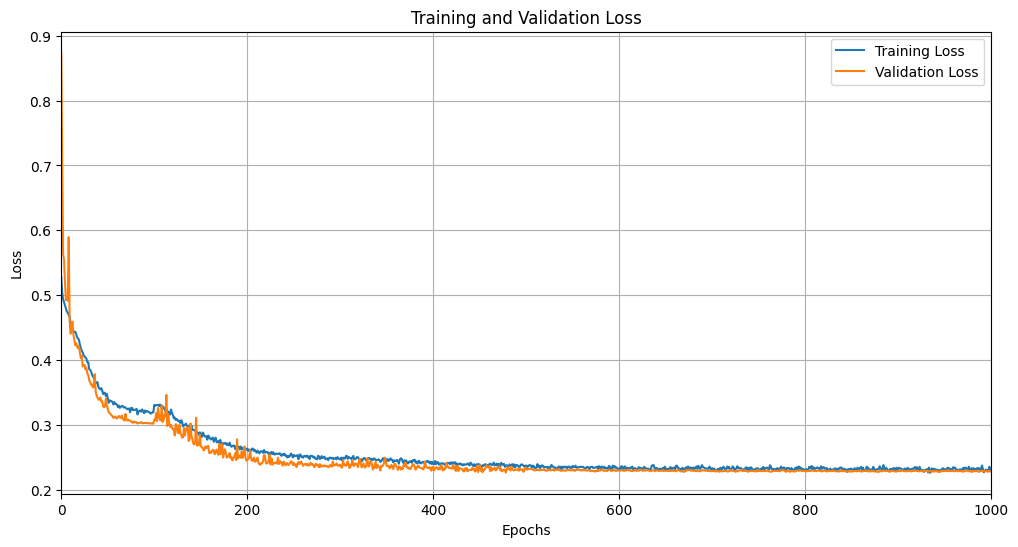

In [70]:
plt.figure(figsize=(12, 6)) 
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xlim(0, 1000)  
plt.grid()  
plt.show()
